# 1. Intro

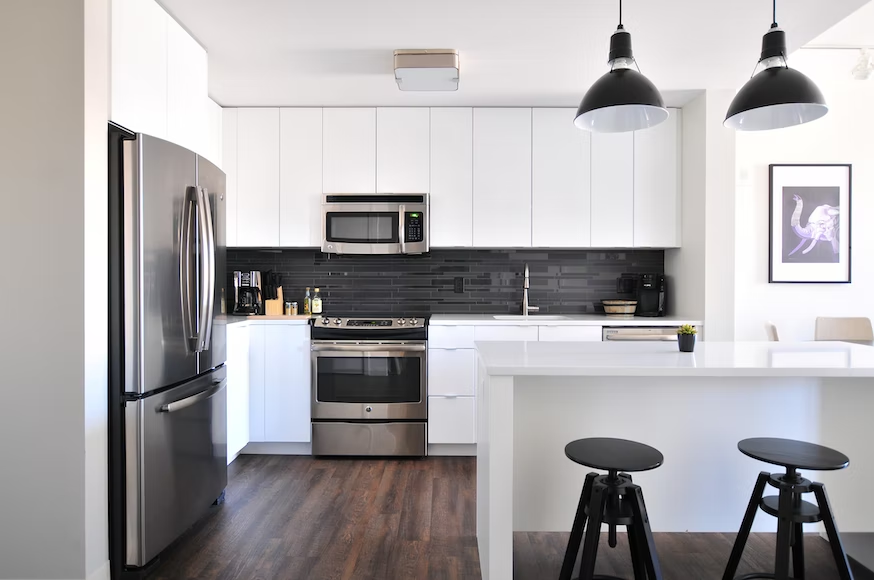

안녕하세요 ! Stage 4에 오신 데이커 여러분들을 환영합니다 👋👋



벌써 스테이지의 절반이 지나갔네요.

Stage 3에서는 데이터 전처리를 해보고 선형회귀를 통해 아파트 실거래가 예측까지 해봤는데요.



Stage 4에서는 모델이 예측을 잘 하고 있는지 모델의 성능을 평가하고 선형회귀보다 더 성능이 좋은 모델이 있는지 찾아보는 시간을 가져봅시다 !

---

# 2. 데이터 전처리 복습

stage 3에서 데이터 전처리를 진행했던 것, 기억나시나요?

stage 4에서도 실습을 진행해야 하니, 우선 데이터를 불러오는 것부터 전처리 과정까지 빠르게 수행해 보도록 할게요! 😀

In [ ]:
# 주피터라이트에서 seaborn 사용하기
import micropip
await micropip.install('seaborn')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# train 데이터를 불러옵니다.
train = pd.read_csv('./train.csv')

In [2]:
# 평당 아파트 실거래가 파생변수를 생성합니다.
train['price_per_area'] = train['transaction_real_price'] / train['exclusive_use_area']*3.3

# 아파트 연식 변수를 생성합니다.
train['year'] = train['transaction_year_month'].astype(str).str[:4].astype(int)
train['month'] = train['transaction_year_month'].astype(str).str[4:].astype(int)

# 거래일
train.loc[(train['transaction_date'] == '21~30') | (train['transaction_date'] == '21~28') | (train['transaction_date'] == '21~29'), 'transaction_date'] = '21~31'

# 아파트 연식
train['age'] = train['year'] - train['year_of_completion']

# 재건축여부
train.loc[train['age'] < 20, 'reconstruction'] = 'NO'
train.loc[train['age'] >= 20, 'reconstruction'] = 'YES'

In [3]:
# re 모듈을 선언하고 괄호와 괄호 안 문자를 찾아서 삭제합니다.
from tqdm import tqdm
import time
import re

regex = "\(.*\)"

for i in tqdm(range(len(train))):
   train.at[i, 'apt'] = re.sub(regex, '', train.at[i, 'apt']) 

100%|█████████████████████████████████████████████████████████████████████| 1216553/1216553 [00:31<00:00, 38541.73it/s]


In [ ]:
# 상위 20개 아파트 이름 리스트를 생성합니다.
apt_brand_list = train['apt'].value_counts()[:20].index

# 상위 20개 아파트 이름에 속하는지를 구별하는 변수를 생성합니다.
train['branded'] = False

# 아파트 이름이 리스트 안의 브랜드를 가지고 있다면 대표 이름으로 바꿔고 branded 변수를 True로 바꿉니다.
for brand in tqdm(apt_brand_list):
  train['apt'].loc[train['apt'].str.contains(brand)] = brand
  train['branded'].loc[train['apt'].str.contains(brand)] = True

# branded 변수가 False인 아파트를 others라는 이름으로 통합합니다.
train['apt'].loc[~train['branded']] = 'others'

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_6888\2881525954.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apt'].loc[train['apt'].str.contains(brand)] = brand
C:\Users\USER\AppData\Local\Temp\ipykernel_6888\2881525954.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['branded'].loc[train['apt'].str.contains(brand)] = True
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.60s/it]
C:\Users\USER\AppData\Local\Temp\ipykernel_

In [5]:
# 평단가 평균을 기준으로 아파트명을 오름차순 정렬해줍니다. 
apt_price = train.groupby('apt')['price_per_area'].mean().sort_values(ascending=True)

# 평단가 평균이 낮은 순으로 아파트명에 0부터 19까지 부여해줍니다.
for i, apt in enumerate(tqdm(apt_price.index)):
    train['apt'].loc[train['apt'] == apt] = i

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_6888\689223827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apt'].loc[train['apt'] == apt] = i
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.29it/s]


In [6]:
# object 타입이기 때문에 이를 int64 형태로 변경합니다.
train.loc[:,'apt'] = train.loc[:,'apt'].astype('int')

In [7]:
# 로그변환
train['transaction_real_price'] = np.log1p(train['transaction_real_price'])

# 이상치 제거
train  = train.loc[train['price_per_area']>= 200, :]

In [8]:
# 범주형 변수와 수치형 변수로 분리
train_X_cat = train[['city','transaction_date', 'reconstruction']]
train_X_num = train[['exclusive_use_area','floor', 'age']]

In [9]:
# 라벨인코딩
le = LabelEncoder()
train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])
train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])
train_X_cat.loc[:,'reconstruction'] = le.fit_transform(train_X_cat.loc[:,'reconstruction'])

C:\Users\USER\AppData\Local\Temp\ipykernel_6888\1386556571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])
C:\Users\USER\AppData\Local\Temp\ipykernel_6888\1386556571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])
C:\Users\USER\AppData\Local\Temp\ipykernel_6888\1386556571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

In [10]:
# 정규화 
minmax_scaler = MinMaxScaler()
train_minmax = minmax_scaler.fit_transform(train_X_num)
train_minmax = pd.DataFrame(train_minmax, index=train_X_num.index, columns=train_X_num.columns)

In [11]:
# 라벨인코딩과 정규화가 완료된 데이터 합치기
X = pd.concat([train_minmax, train_X_cat, train['apt']], axis=1)

In [12]:
# 예측해야 할 변수를 y라는 객체에 따로 저장합니다.
y = train['transaction_real_price']

---

# 3. 과대적합(Overfitting) vs 과소적합(underfitting)

**<font color=red>과대적합(Overfitting)</font>** 이란, 말 그대로 `학습 데이터를 과도하게 학습하는 것`을 말합니다. <br>
즉, 모델이 학습 데이터에만 과도하게 최적화되어 실제 예측을 다른 데이터로 수행할 경우 예측 성능이 떨어지는 것을 의미해요. <br>



그런데 고정된 학습 데이터와 테스트 데이터로 평가하다 보면, <br>
테스트 데이터에만 최적의 성능을 발휘할 수 있도록 편향되게 모델을 유도하는 경향이 생기게 됩니다. <br>
결국 해당 테스트 데이터에만 과대적합되는 학습 모델이 만들어져 다른 테스트용 데이터가 들어올 경우에는 성능이 저하되는 것이죠 😥

반대로 **<font color=red>과소적합(underfitting)</font>** 이란, `모델 학습이 제대로 수행되지 않아 학습 데이터를 충분히 설명하지 못 하는 것`을 의미합니다. <br>
다시 말해, 모델이 너무 단순해서 학습 데이터의 구조나 패턴을 정확하게 반영하지 못하는 문제입니다.

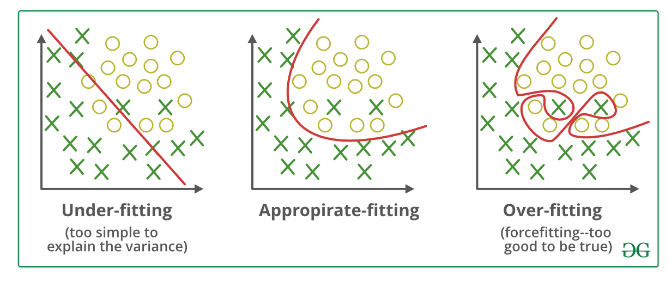

*(출처: https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)*

과대적합과 같은 문제를 개선하기 위해, <font color=purple>교차 검증</font>을 이용해 더 다양한 학습과 평가를 수행하게 되는 것입니다 😊

교차 검증은 이따가 학습할테니 조금만 기다려주세요!

---

# 4. 앙상블(ensemble)

<font color=red>**앙상블(ensemble)**</font>은 데이터 학습 방법의 일종으로, 좋은 성능을 얻기 위해 다수의 학습 알고리즘을 사용하는 것을 말합니다.

성능이 좋은 학습기 하나를 사용하는 것보다 성능이 약한 학습기 여러 개를 사용하는 것이 더 정확한 결과를 낼 수 있습니다.

예를 들어 설명해볼게요 🙂

물리학 교수 1명으로 이루어진 팀과 여러 전공의 대학원생 10명으로 이루어진 팀이 퀴즈 대회에 참가했습니다. <br>
두 팀 중 어느 쪽의 우승 가능성이 더 높을까요?

아마 대학원생 팀의 우승 가능성이 더 높을 것입니다.
이게 바로 집단지성의 힘이죠 👍

이처럼 개별 학습기의 성능은 낮지만 합치면 강해진다는 원리를 이용한 것이 바로 앙상블 학습이랍니다!

Stage 4에서는 앙상블 학습의 종류 중 배깅(Bagging)에 대해 자세하게 알아보도록 하겠습니다.

---

## 4.1 배깅(Bagging)

<font color=red>**배깅(Bagging)**</font>은 'Bootstrap + Aggregating'의 합성어입니다.



여기서 부트스트랩(Bootstrap)이란, 표본 분포를 구하기 위해 데이터를 여러 번 복원 추출(랜덤 샘플링)하는 방법인데요. <br>
이때 중복을 허용하기 때문에 동일한 데이터가 여러 번 선택될 수도 있습니다.

배깅은 이러한 부트스트랩을 통해서 다양한 데이터셋을 만들고, 이를 학습시킨 모델을 모으는(Arregating) 방법입니다.


예를 들어 train 데이터가 1000개라고 합시다. <br>
1000개의 train 데이터를 모두 다 사용하지 않고, 500개만 여러 번 복원추출하여 각각 학습한 결과값들을 이용하여 분류기를 만드는 원리입니다.

---

# 5. 의사결정나무(Decision Tree)

여러분, <font color=green>**스무고개**</font>라는 게임 아시나요?

생물인지 무생물인지, 생물이라면 동물인지 식물인지 등등 계속 꼬리의 꼬리를 물고 나가며 최종적인 답을 예측하는 게임인데요.

<font color=red>**의사결정나무(Decision Tree)**</font>란 스무고개처럼 의사 결정 규칙을 나무 구조로 나타내어 전체 자료를 몇 개의 소집단으로 분류하거나 예측을 수행하는 분석 방법입니다.

즉, 데이터의 특징에 대한 질문을 기반으로 데이터를 분리해 예측하는 방법이에요.
<br><br>
예시를 한번 보겠습니다.

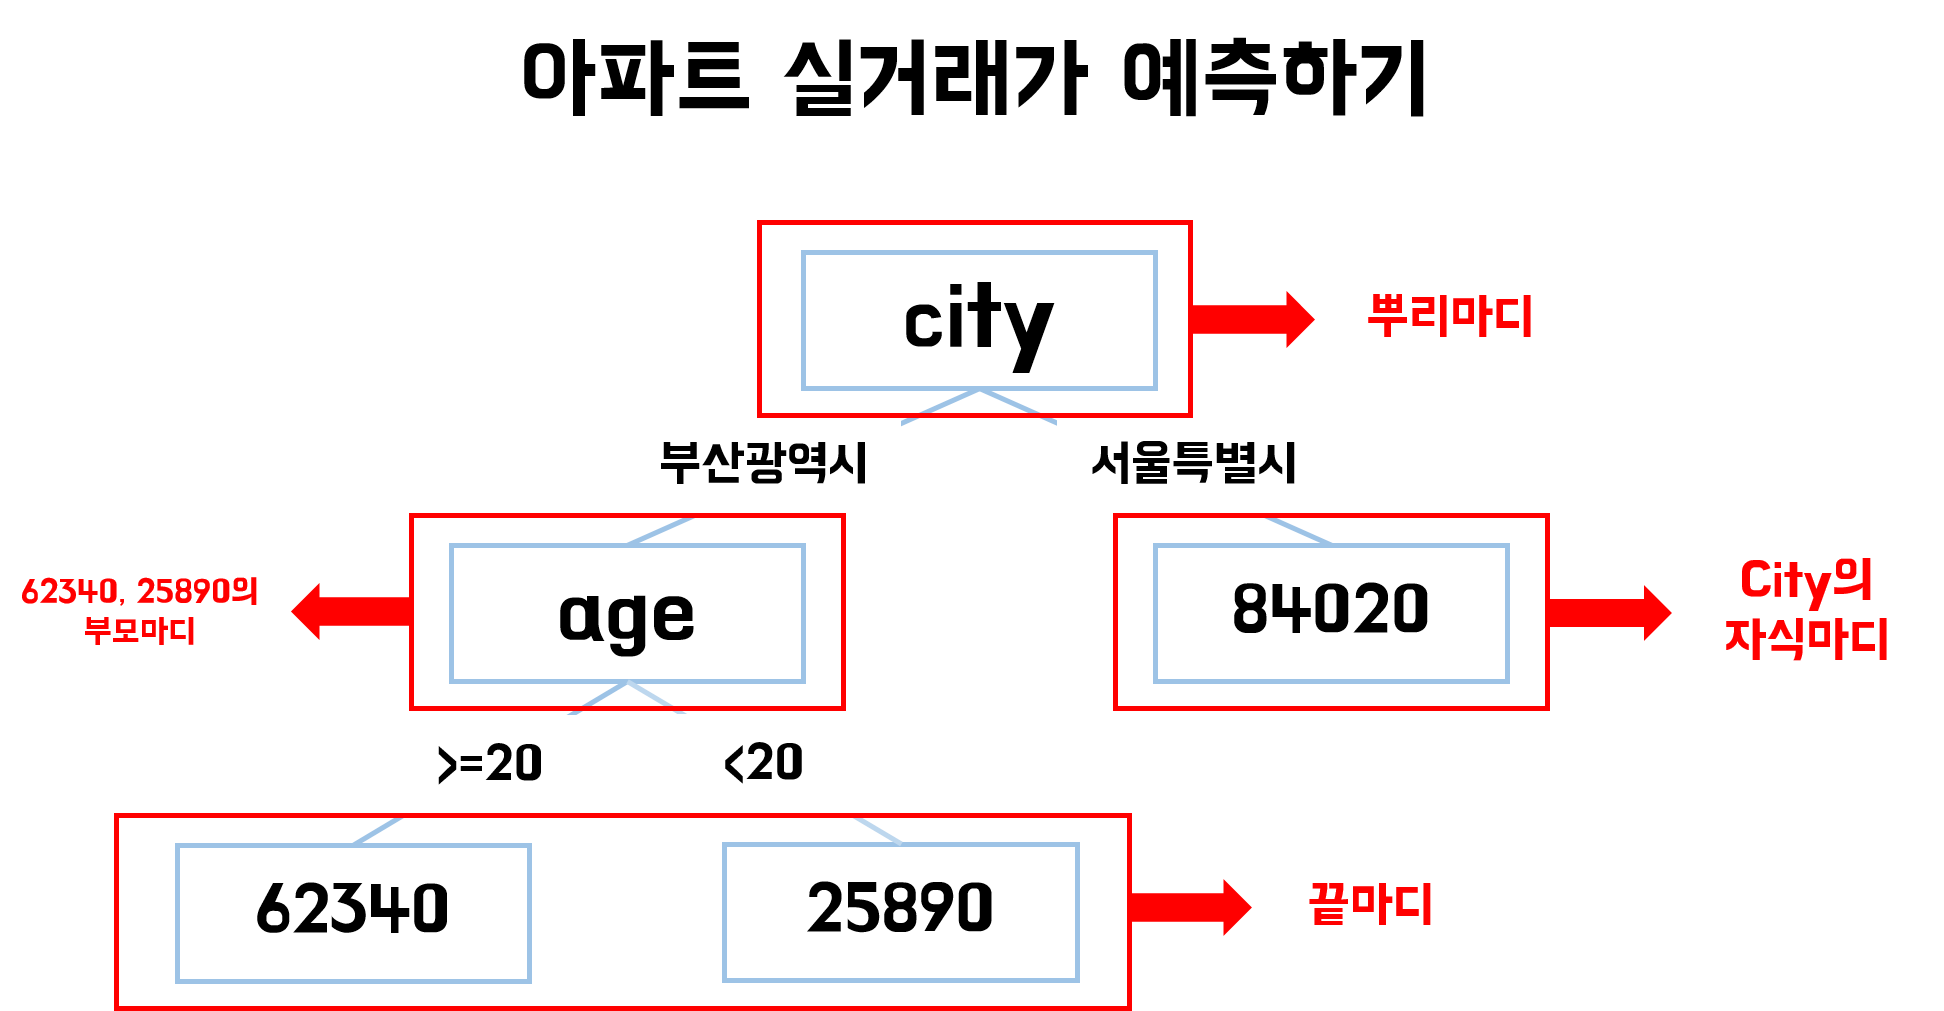

위 예시는 여러분의 이해를 돕기 위해 임의로 의사결정나무를 만든 것입니다.

맨 위의 뿌리마디를 보면 부산인지 서울인지, 아파트 연식이 20년 이상인지 미만인지 등등 계속 가지를 뻗어나가는 형식을 볼 수 있습니다. <br>
최종적으로는 마디의 평균으로 실거래가를 예측합니다 !

**의사결정나무의 구성요소**는 아래와 같습니다.

- 뿌리마디(root node) : 시작되는 마디로 전체 자료를 포함
- 자식마디(child node) : 하나의 마디로부터 분리되어 나간 2개 이상의 마디들
- 부모마디(parent node) : 주어진 마디의 상위마디
- 끝마디(leaf node) : 자식마디가 없는 마디
- 중간마디(internal node) : 부모마디와 자식마디가 모두 있는 마디
- 가지(branch) : 뿌리마디로부터 끝마디까지 연결된 마디들
- 깊이(depth) : 뿌리마디부터 끝마디까지의 중간마디들의 수

그렇다면 의사결정나무의 가지는 어떻게 분리되는 것일까요? 😮

그 원리를 알기 위해서는 우선 몇 가지 개념을 숙지해야 하는데요. 

우리가 스무고개를 할 때도 어떤 질문을 하느냐에 따라 답을 찾는 속도가 달라지죠?

따라서 의사결정나무도 <font color=blue>각 마디(노드)의 불순도가 낮은 방향으로, 정보획득량이 높은 방향으로</font> 분류해나가는 것이 최적의 방법입니다.

불순도 측정 기준은 크게 **엔트로피**와 **지니지수**가 있습니다.

- 정보획득량 : 말 그대로 어떤 속성의 정보가치를 수치화한 것을 뜻합니다.
- 엔트로피, 지니지수 : 데이터의 무질서도(불순도)를 수치화한 것을 뜻합니다. 



---

# 6. 랜덤포레스트(RandomForest)

앞서 살펴본 의사결정나무는 범주형, 수치형 데이터를 모두 예측할 수 있다는 장점이 있는 반면 오버피팅, 즉 과대적합에 취약하다는 단점이 있습니다.

이 단점을 보완한 모델이 바로 **랜덤포레스트**입니다 👍

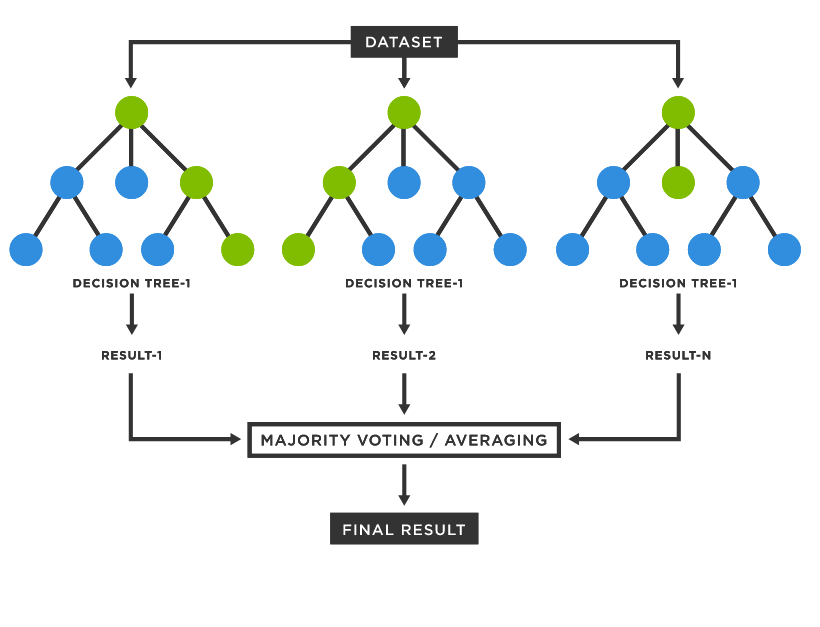

>출처 : https://www.tibco.com/ko/reference-center/what-is-a-random-forest

<font color=red>**랜덤포레스트(RandomForest)**</font>는 훈련 과정에서 만들어진 다수의 의사결정나무로부터 분류된 결과를 집계하여, <br>
분류문제의 경우 최종적으로 분류된 데이터, 회귀문제의 경우 평균예측치를 출력하는 모델입니다.

여러분, 혹시 **'랜덤포레스트'의 의미**를 생각해본 적 있으신가요? 😮😮 <br>
의사결정나무에서는 모든 데이터, 모든 feature를 다 사용해서 트리를 만들었지만 랜덤포레스트는 다릅니다.

* 랜덤포레스트를 구성하는 의사결정나무를 만들 때는 데이터를 랜덤하게 추출하며, 트리 분할기준이 되는 feature 또한 랜덤으로 추출합니다. <br>
그래서 <font color=purple>랜덤(Random)</font>이라는 단어가 들어가는 것이죠!

* 이런 과정을 반복해 의사결정나무를 여러개 만든 후, 결과의 <font color=green>**평균**</font>들을 구합니다. <br>
이렇게 수많은 의사 결정 나무들을 모아 숲을 구성하기 때문에 <font color=purple>포레스트(Forest)</font>라고 합니다.

따라서 랜덤 포레스트는 독립적으로 의사결정나무를 여러 개 만들어 **임의(random)의 숲**을 구성하기 때문에 오버피팅을 피할 수 있습니다. <br>
다수의 나무들로부터 결과를 집계하는 만큼 오버피팅이 나타나는 나무의 영향력을 줄일 수 있거든요.

그러면 이제 **랜덤포레스트의 특징**을 알아보겠습니다!

* <font color=hotpink>장점</font>: 데이터 스케일링이 필요하지 않음

* <font color=hotpink>단점</font>: 정해주어야 할 하이퍼 파라미터의 개수가 많고, 학습 시간이 오래 걸림

* <font color=hotpink>주의할 점</font>: 배깅과 랜덤포레스트는 다름! ⚠⚠<br>
랜덤포레스트는 부스트랩을 통해 데이터의 독립성을 보장하고, 각 나무를 구성하는 피처를 랜덤하게 뽑음으로써 독립성을 보다 부여하게 됨. <br>
즉, 랜덤포레스트는 배깅에 독립성을 더 부여한 모델임

이제 배깅과 랜덤포레스트의 차이점을 명확하게 알 수 있겠죠?💪

랜덤포레스트는 sklearn 패키지에 존재하며, 다음과 같은 코드를 통해 불러올 수 있습니다 😊



`from sklearn.ensemble import RandomForestRegressor` <br>
`rf = RandomForestRegressor()`

---

### 6.1 변수중요도(Feature Importance)

<font color=red>**변수중요도(Feature Importance)**</font>란 변수별로 예측에 주는 영향력을 수치로 나타낸 것입니다.


랜덤포레스트에서 변수중요도는 특정 feature가 트리를 분할하는데 얼마나 기여를 했는지를 나타냅니다.

변수중요도를 통해 어떤 변수가 예측에 도움을 주는지 알 수 있답니다 !



그렇다면 데이터로 실습을 진행해보겠습니다 😜

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
model_rf = rf.fit(X, y)

`fit된 모델.feature_importances_`을 통해 어떤 컬럼이 얼만큼 예측력에 도움이 되는지를 알 수 있습니다 !

In [16]:
rf_feature_importances = model_rf.feature_importances_
rf_feature_importances

array([0.48443658, 0.03429909, 0.08210488, 0.35919708, 0.00980433,
       0.00080158, 0.02935645])

흠... 🤔 그런데 이 값들이 각각 어떤 컬럼의 것인지 어떻게 알 수 있을까요? <br>
fit시킨 컬럼 순서대로 값들을 매칭시켜주면 됩니다!

`독립변수.columns`를 이용하면 컬럼의 순서를 볼 수 있어요 👍

In [17]:
X.columns

Index(['exclusive_use_area', 'floor', 'age', 'city', 'transaction_date',
       'reconstruction', 'apt'],
      dtype='object')

데이터 프레임으로 변환한 다음, 표의 형태로 확인해볼까요?

In [18]:
rf_feature_importance = pd.DataFrame(model_rf.feature_importances_, X.columns , columns =['feature importance'])
rf_feature_importance

,feature importance
exclusive_use_area,0.484437
floor,0.034299
age,0.082105
city,0.359197
transaction_date,0.009804
reconstruction,0.000802
apt,0.029356


In [19]:
# 변수중요도 순서로 정렬합니다.
rf_feature_importance = rf_feature_importance.sort_values('feature importance', ascending = False)

또한 변수중요도는 그래프를 통해서도 나타낼 수 있는데요. <br>
stage 2에서 seaborn 패키지를 이용해 그래프를 그리는 법을 배웠던 게 기억 나시나요? 😉



`sns.barplot`을 이용해 가로 막대그래프로 변수중요도를 그려봅시다 !

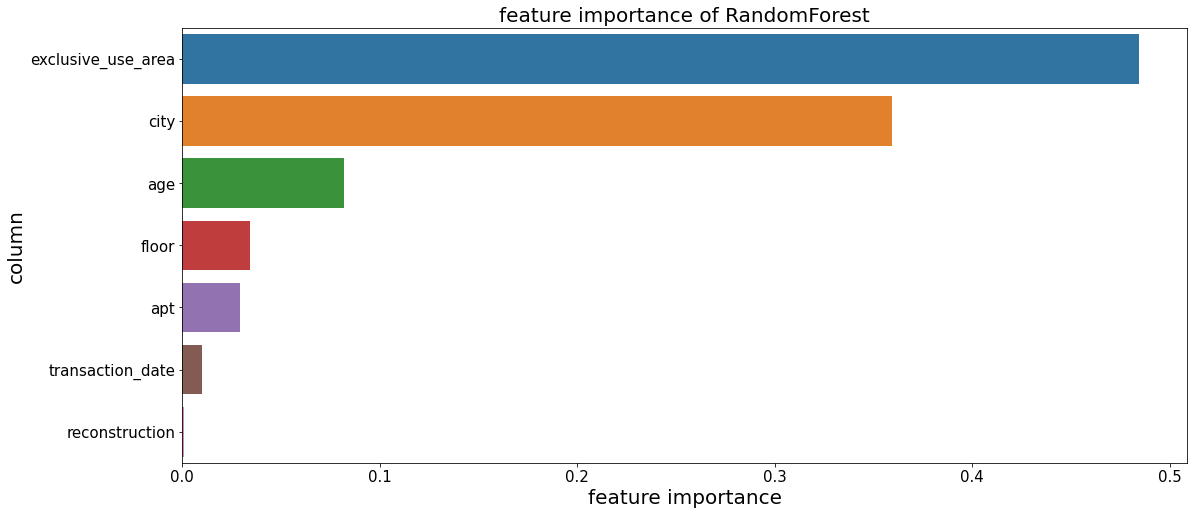

In [20]:
# seaborn의 barplot을 이용하여 변수의 중요도 순서대로 나타내봅시다.

plt.figure(figsize = (18,8))
sns.barplot(x ='feature importance', y = rf_feature_importance.index ,orient='h', data = rf_feature_importance)
plt.title('feature importance of RandomForest', size = 20)

plt.xticks(size = 15)
plt.yticks(size = 15)

plt.xlabel('feature importance', size = 20)
plt.ylabel('column', size = 20)
plt.show()

그래프를 이용하니, 각 컬럼과 그에 해당하는 값들이 더 잘 파악되지요? 😄<br>
해석해보자면, 역시 전용면적(exclusive_use_area)의 변수중요도가 가장 높다는 것을 알 수 있네요!

---

# 7. 모델 성능평가 종류

머신러닝의 학습은 크게 <font color=red>분류</font>와 <font color=red>회귀</font>, 두 가지로 나누어집니다.

분류는 예측해야 할 값이 범주형일때, 회귀는 예측해야 할 값이 숫자형일 때를 의미합니다. <br>
따라서 모델 성능을 평가하는 방법은 분류인지 회귀인지에 따라 달라지는데요.

우리 대회에서는 숫자형인 아파트 실거래가를 예측해야 하므로, 회귀인 경우에 해당하겠지요? 😊

---

## 7.1 회귀

회귀 모델의 성능을 평가하는 기준은 <font color=green>실제값과 예측값의 차이</font>입니다! <br>
따라서 실제값과 예측값의 차이가 작을수록 모델의 성능이 좋군! 이라고 생각하면 되겠죠?

---

### MSE

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(\widehat{Y_{i}}-{Y_i})^2$$

**MSE**는 각 데이터별 예측값과 실제값의 차이의 제곱합의 평균입니다. <br>
제곱을 해주기 때문에 틀리게 예측할수록 제곱으로 값이 늘어납니다. 따라서 이상치에 민감하다고 할 수 있는데요. <br>

글로 보니 이해가 잘 되지 않는다구요? 😂 그러면 예시 데이터를 함께 살펴보겠습니다!

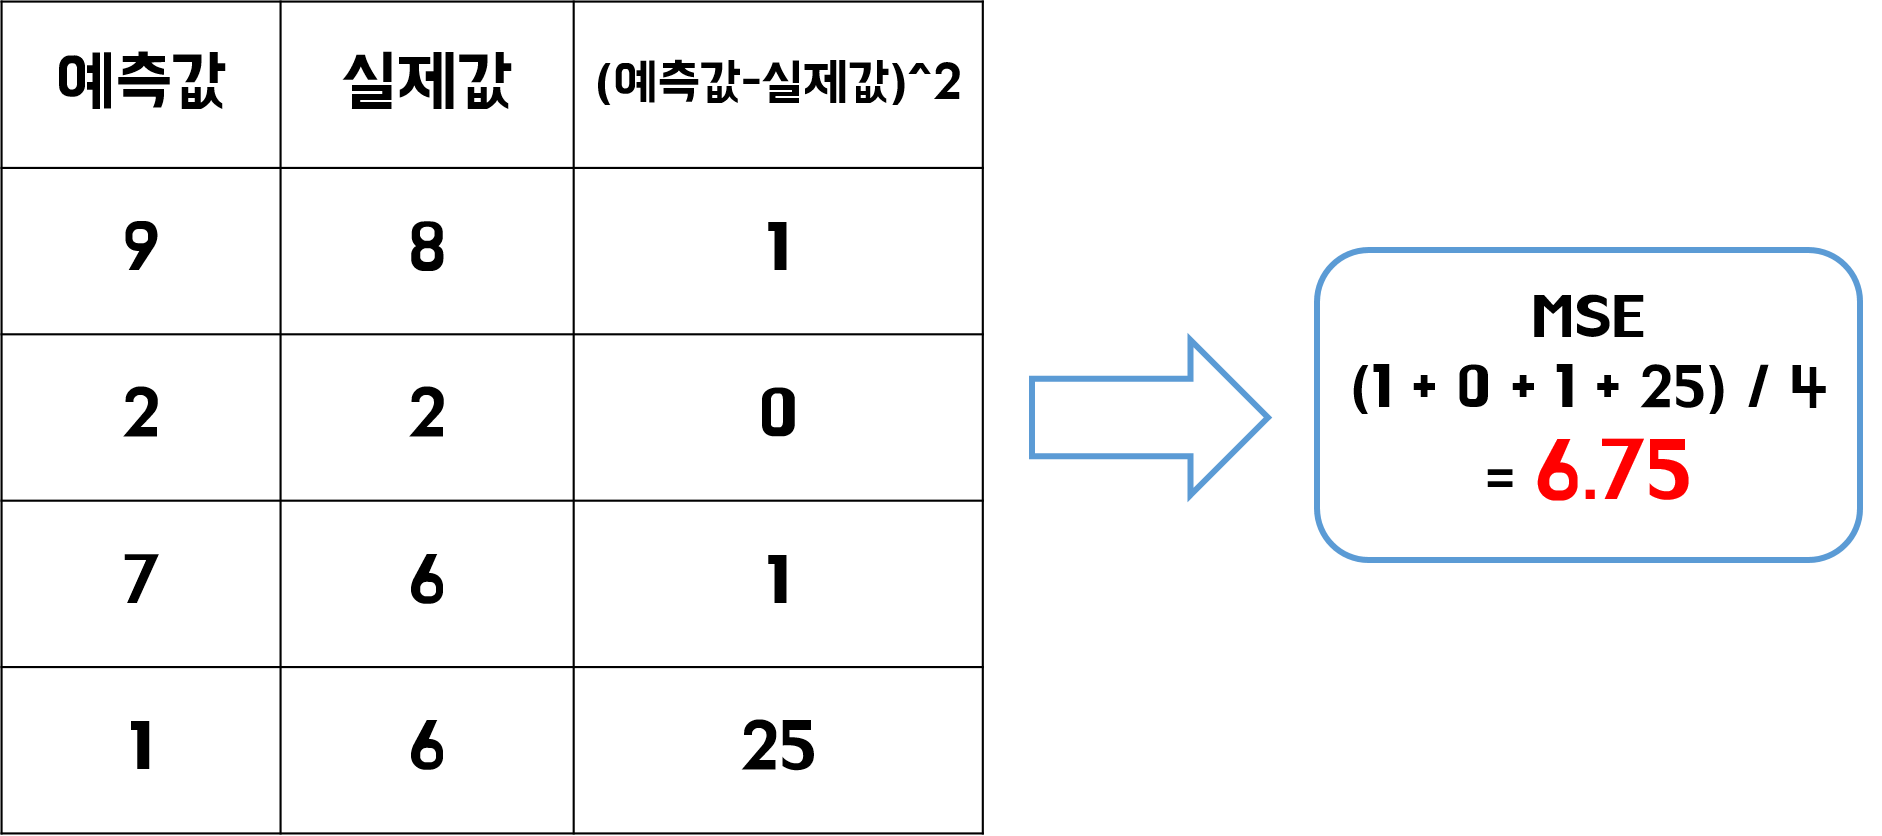

와우! 예시 덕분에 이제 MSE를 계산하는 방법을 더 잘 이해하게 된 것 같네요 😉

---

### RMSE

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\widehat{Y_{i}}-{Y_i})^2}$$

**RMSE**는 MSE의 제곱근 입니다.

데이터가 너무 많으면 MSE가 값이 너무 커지기 때문에, 제곱근인 RMSE를 이용합니다. <br>
또한 제곱근을 취해줌으로써 계산이 더 빨라진다는 장점도 있습니다 👍

우리가 분산 대신 표준편차를 쓰는 것처럼요.

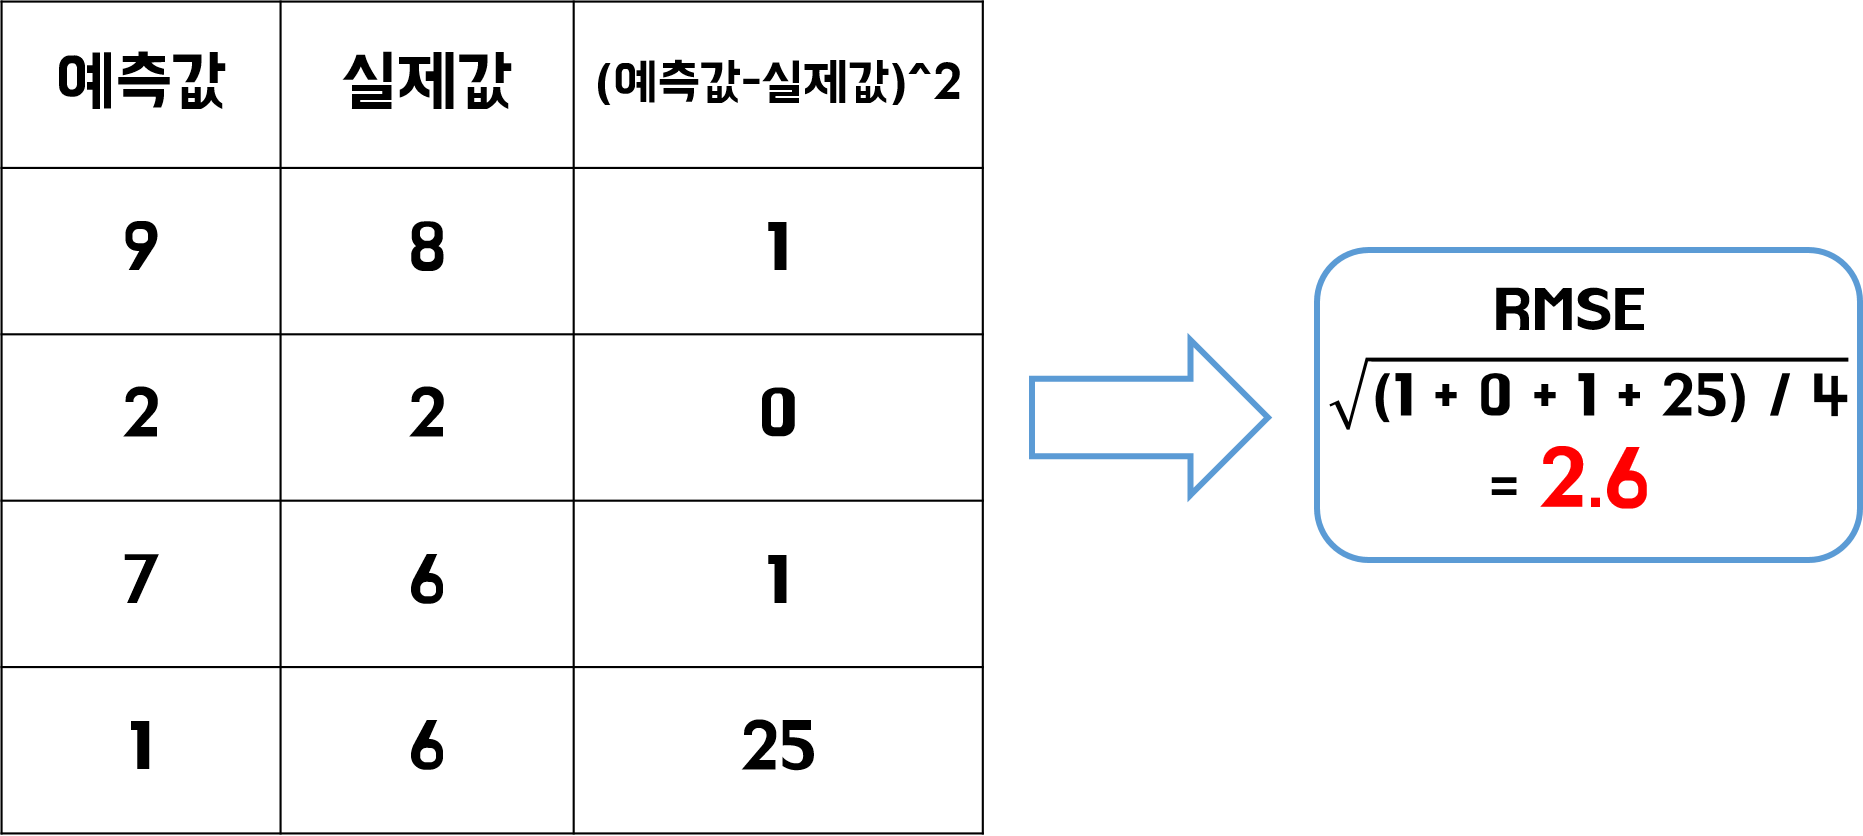

위 데이터를 기준으로 하면 RMSE값은 $\sqrt{MSE} = RMSE = 2.6 $ 입니다 !

---

### MAE

$$MAE = \frac{1}{n}\sum_{i=1}^{n}\left |\hat{Y_{i}}-{Y_i}\right |$$

**MAE**는 실제값과 예측값의 차이의 평균을 의미합니다. MSE와 달리 절대값을 취해주기 때문에 MSE보다 이상치에 덜 민감합니다.

예시를 한번 보도록 하겠습니다.

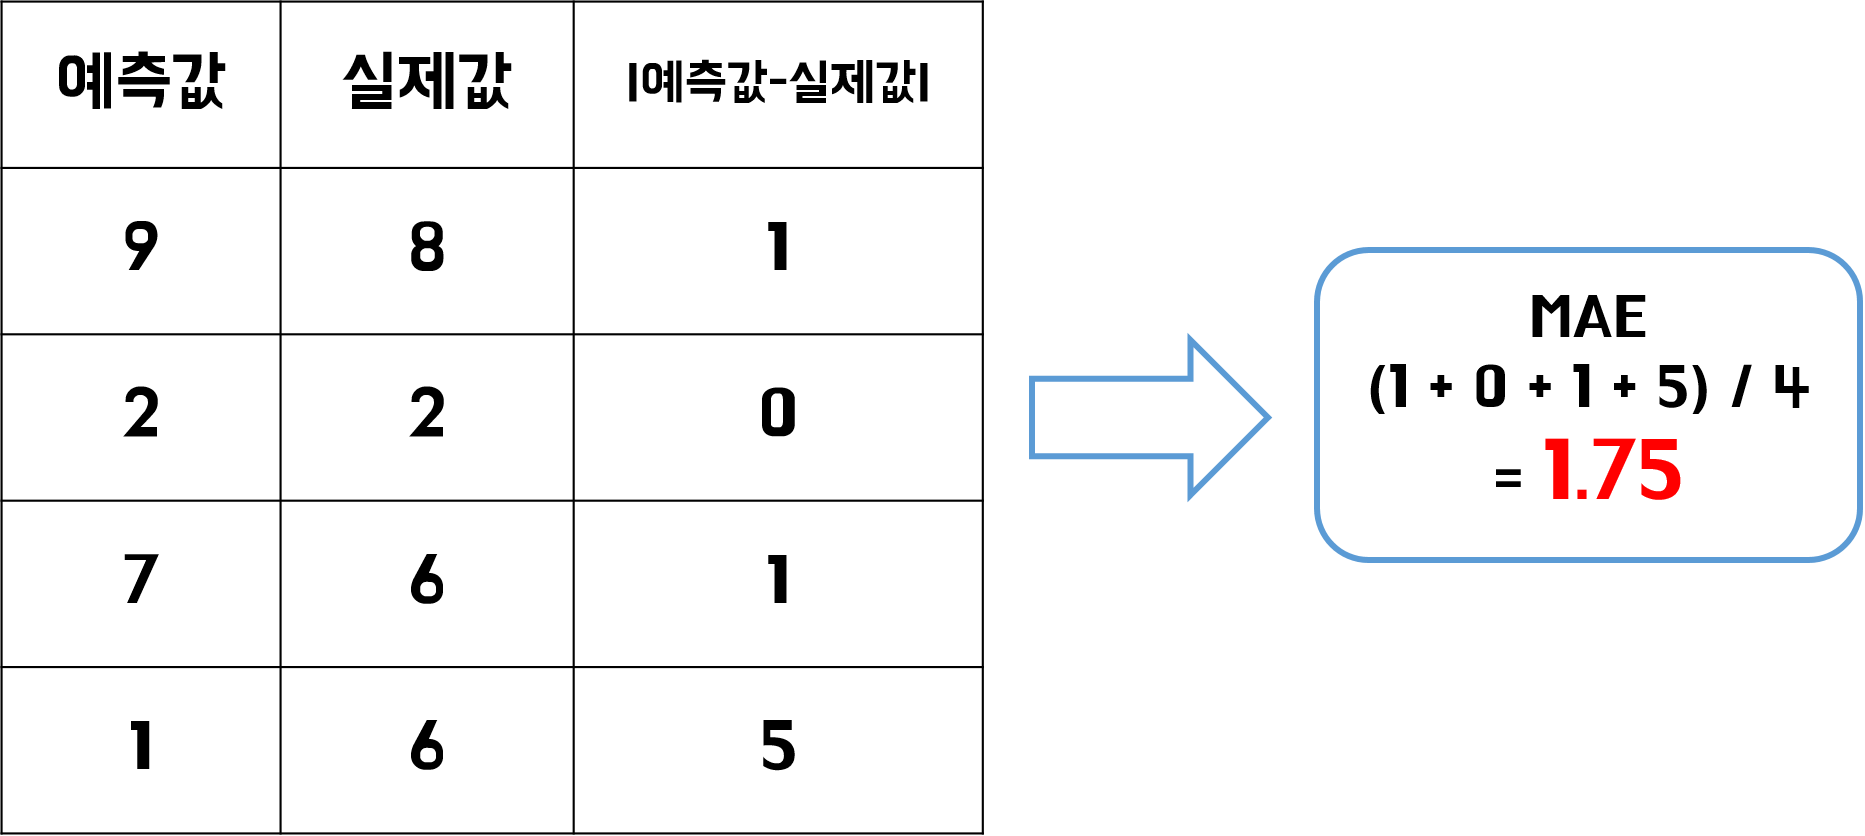

실제 예시를 보니까 MSE, RMSE, MAE에 대한 이해가 너무 잘 되지 않나요? 😘

---

# 8. 하이퍼파라미터

<font color=red>**하이퍼파라미터(Hyper parameter)**</font>란 모델링을 할 때 사람이 직접 지정해주어야 하는 값을 뜻합니다.

반대로 파라미터(parameter)는 모델링을 할 때 모델링 내부에서 자동으로 정해지는 값을 뜻합니다.



하이퍼파라미터 라는 단어는 너무 길죠?
그래서 보통 하이퍼파라미터를 파라미터라고 줄여 부른답니다.

그래서 누군가가 여러분에게 "이 모델은 파라미터를 조정해야 해요!"라고 말한다면,<br>
"아, 하이퍼파라미터를 조정해야 한다는 의미구나."하고 이해하면 된답니다 😊


그렇다면 랜덤포레스트의 파라미터를 살펴보겠습니다.

---

## 8.1 랜덤포레스트의 하이퍼파라미터

- n_estimators : 몇 개의 의사결정나무를 사용할지 결정합니다.
무작정 트리 개수를 늘리면 성능 향상 정도에 비해 학습 시간이 오래 걸립니다.

- min_samples_split : 노드(마디)를 분할하기 위한 최소한의 샘플 데이터 수로 오버피팅을 막기위해 사용합니다. 값이 작을수록 노드(마디)가 많아져 오버피팅이 될 가능성이 증가합니다.

- min_samples_leaf : 리프노드가 되기 위한 최소한의 샘플 데이터 수이며 과적합을 제어하는데 사용합니다. 값이 작을수록 오버피팅 가능성이 증가해요.
만약 분류문제에서 특정 독립변수 클래스가 많은 불균형 데이터의 경우라면, 작은 값으로 설정하는 게 좋아요.

- max_features : 최적의 분할을 위해 고려할 피처의 최대 개수입니다.

- max_depth : 트리의 최대 깊이로, 깊이가 너무 깊어지면 오버피팅이 될 수 있으므로 적절히 제어하는 것이 필요합니다.

- max_leaf_nodes : 리프노드의 최대 개수를 뜻합니다.

그런데 위의 값은 어떤 기준으로 조정해야 하나요?
또한 파라미터의 값이 너무 크다, 작다라는 것은 어떻게 알 수 있나요?

사실 정답은 아무도 모릅니다...😅😅

그래서 튜닝 과정을 통해 하이퍼파라미터를 적절히 조정해주어야 한답니다.

---

## 8.2 하이퍼파라미터 튜닝

우리는 위에서 하이퍼파라미터가 무엇인지 알아봤죠?

그렇다면 이번에는 튜닝을 통해 모델이 최적의 성능을 낼 수 있는 파라미터 값을 찾아보도록 합시다 !

튜닝 방법에는 크게 그리드서치와 랜덤서치가 있습니다.

위에서 배웠던 랜덤포레스트의 하이퍼파라미터 튜닝을 진행해봅시다.

---

### 그리드서치(Grid Search)

<font color=red>**그리드 서치(Grid Search)**</font>는 설정한 하이퍼파라미터 범위의 모든 경우의 수를 전부 탐색하여, 그 경우의 수 중 가장 좋은 성능을 낸 파라미터 값을 채택하는 방법입니다.

그리드서치 과정을 알아보겠습니다 😁

① 먼저 sklearn의 GridSearchCV 함수를 import로 불러옵니다.

`from sklearn.model_selection import GridSearchCV`

② 랜덤포레스트의 하이퍼파라미터 값이나 범위를 
딕셔너리 형태로 지정합니다.

`params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}`

③ GridSearchCV를 이용하여 train 데이터에 fitting시켜 
최적의 하이퍼파라미터값을 찾습니다.

`grid_cv = GridSearchCV(모델, param_grid=파라미터, cv=cross validation을 몇번 할것인지, n_jobs=-1, scoring=성능평가기준)` <br>
`grid_cv.fit(X,y)`

이해가 되시나요?

아직 잘 와닿지 않으신다면, 이번에도 예시를 통해 이해해보도록 하겠습니다!




그런데 사실 모든 하이퍼파라미터를 정해주어야 할 필요는 없습니다 😉

예측에 도움이 될 거라고 판단되는 변수에 대해서만 그리드서치를 통해 최적값을 찾아내면 됩니다. 

또한 그리드서치는 데이터가 많을수록 값의 범위를 너무 넓게 잡거나, 한꺼번에 많은 하이퍼파라미터를 조정하려고 하면 시간이 매우 오래 걸립니다 😥

따라서 아래 예시에서는 `n_estimators`와 `min_samples_split`, 두 개의 파라미터만 조정해보겠습니다 !

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [22]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

학습 데이터와 검증 데이터를 나눠서 그리드서치를 진행하고, 성능평가 기준은 RMSE로 설정하겠습니다.

학습 데이터를 왜 나누는지, 왜 RMSE에 마이너스를 붙이는지는 교차검증 파트에서 자세히 알아보도록 하겠습니다 👩 <br>


In [23]:
# train 데이터와 validation 데이터 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
# RMSE의 음수값 계산 함수
def MINUS_RMSE(y_real,y_pred):
  return -mean_squared_error(y_real, y_pred)**0.5 

In [ ]:
# 그리드서치의 파라미터 지정
params_grid ={
    'n_estimators':[10,50],
    'min_samples_split':[2,4,6],
}

In [27]:
grid_cv = GridSearchCV(rf, param_grid=params_grid, cv=2, scoring=make_scorer(MINUS_RMSE, greater_is_better=False))
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 50]},
             scoring=make_scorer(MINUS_RMSE, greater_is_better=False))

여기서 make_scorer에는 커스텀한 성능 지표가 들어가고, `greater_is_better=False`은 그리드 서치를 진행하면서 score값이 낮은 값을 선택하도록 합니다.

학습이 다 끝났다면, 가장 좋은 성능을 낸 파라미터 값이 얼마인지 확인해봐야 합니다 😃

- grid_cv.best_score_ : 가장 좋은 성능을 낸 성능 점수를 출력합니다.

- grid_cv.best_params_ : 최고 성능을 낸 파라미터를 출력합니다.

- grid_cv.best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형을 출력합니다.

In [28]:
print('best score :', grid_cv.best_score_)
print('best parameters :', grid_cv.best_params_)
print('best estimator :', grid_cv.best_estimator_ )

best score : 0.23604007960100842
best parameters : {'min_samples_split': 2, 'n_estimators': 10}
best estimator : RandomForestRegressor(n_estimators=10, random_state=42)


`{'min_samples_split': 2, 'n_estimators': 10}`일 때 가장 성능이 좋네요 👍 <br>
따라서 학습할 때도 `RandomForestRegressor(n_estimators=10, random_state=42)`의 모델을 이용해서 학습하면 최적의 결과를 낼 수 있답니다 🤩

여기서 꿀팁 들어갑니다 🍯🍯🍯

지정해야 할 파라미터의 입력된 경우의 수가 너무 많다면, **range()**로 범위를 지정해주는 방법도 있습니다!

`max_depth : range(1,20,2)` 이면 1부터 20까지 2씩 증가하는 것이므로, 모든 값을 일일히 다 입력하지 않아도 되겠죠?



또한 꿀팁 2번째 🍯🍯🍯

만약 `'max_depth':[6,8,10,12]`에서 12가 최고의 성능을 냈다면, 범위를 12 이상으로 조정해보는건 어떨까요?

---

### 랜덤서치(Random Search)

앞서 살펴본 그리드서치는 시간이 너무 오래 걸린다는 단점이 있습니다.

그래서 <font color=red>**랜덤서치(Random Search)**</font>라는 방법을 이용할 때도 있는데요 🙂 <br>
랜덤서치에서는 가능한 경우의 수를 모두 계산하지 않고, 입력한 파라미터 값을 임의로 선택해 대입하여 최적의 파라미터를 구합니다.

① 먼저 sklearn의 RandomizedSearchCV 함수를 import로 불러옵니다.

`from sklearn.model_selection import RandomizedSearchCV`

② 랜덤포레스트의 하이퍼파라미터 값이나 범위를 
딕셔너리 형태로 지정합니다.

`params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}`

③ RandomizedSearchCV를 이용하여 train 데이터에 fitting시켜 
최적의 하이퍼파라미터 값을 찾습니다.

`random_cv = RandomizedSearchCV(모델, param_distributions=파라미터, cv=cross validation을 몇번 할것인지, n_jobs=-1, scoring=성능평가기준)` <br>
`random_cv.fit(X,y)`

그리드서치랑 방법이 매우 비슷하죠? 

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# 랜덤서치의 파라미터 지정
params_random ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'max_leaf_nodes':[8,12,18],
    'min_samples_split':[8,16,20]
}

---

## 퀴즈

In [ ]:
# RandomizedSearchCV 함수를 이용하여 랜덤서치를 진행해봅시다 !


### 설명

RandomizedSearchCV 함수를 이용하여 랜덤서치를 진행해봅시다 😃

랜덤서치 함수를 만든 후 random_cv에 저장하고, random_cv에 X와 y를 fitting 시키면 됩니다 !

(cv=2, n_jobs=-1, 성능평가기준은 MINUS_RMSE로 설정해봅시다)

### 풀이 - 힌트

그리드서치 과정을 참고해보세요 😊😊

### 풀이 - 정답

```
random_cv = RandomizedSearchCV(rf, param_distributions=params_random, cv=2, n_jobs=-1, scoring=make_scorer(MINUS_RMSE, greater_is_better=False))
random_cv.fit(X_train, y_train)
```

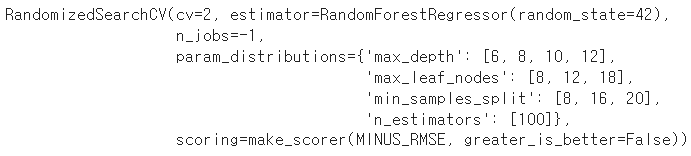

---

랜덤서치 결과를 한번 보도록 하겠습니다 !

In [ ]:
print('best score :', random_cv.best_score_)
print('best parameters :', random_cv.best_params_)
print('best estimator :', random_cv.best_estimator_ )

best score : 0.4025340473508062
best parameters : {'n_estimators': 100, 'min_samples_split': 8, 'max_leaf_nodes': 8, 'max_depth': 8}
best estimator : RandomForestRegressor(max_depth=8, max_leaf_nodes=8, min_samples_split=8,
                      random_state=42)


`{'n_estimators': 100, 'min_samples_split': 8, 'max_leaf_nodes': 8, 'max_depth': 8}`일 때 성능이 가장 좋다는 것을 알았으니,

학습할 때도 ` RandomForestRegressor(max_depth=8, max_leaf_nodes=8, min_samples_split=8, random_state=42)`의 모델을 이용해서 학습하면 최적의 결과를 낼 수 있답니다.

다만 랜덤서치는 모든 경우의 수를 다 탐색하는 것이 아니므로, 그리드서치보다는 정확도나 성능이 떨어질 수 있다는 점을 기억해주세요!

---

# 9. 교차 검증(Cross Validation)

다시 본론으로 돌아가 교차 검증에 대해 더 알아볼게요 😉 <br>

교차 검증을 비유적으로 표현하자면, 수능을 치르기 전에 모의고사를 여러 번 보는 것과 같아요. <br>
수능이 테스트 데이터 세트에 대해 평가하는 거라면, 모의고사는 교차 검증을 통해 많은 학습과 검증 세트에서 알고리즘 학습과 평가를 수행하는 것이죠!

즉, <font color=red>**교차 검증(Cross Validation)**</font>은 `별도의 여러 세트로 구성된 학습 데이터와 검증 데이터 세트에서 학습과 평가를 수행하는 것`이에요. <br>
그리고 각 세트에서 수행한 평가 결과에 따라, 이후 하이퍼 파라미터 튜닝 등의 모델 최적화를 더욱 쉽게 할 수 있습니다 😃

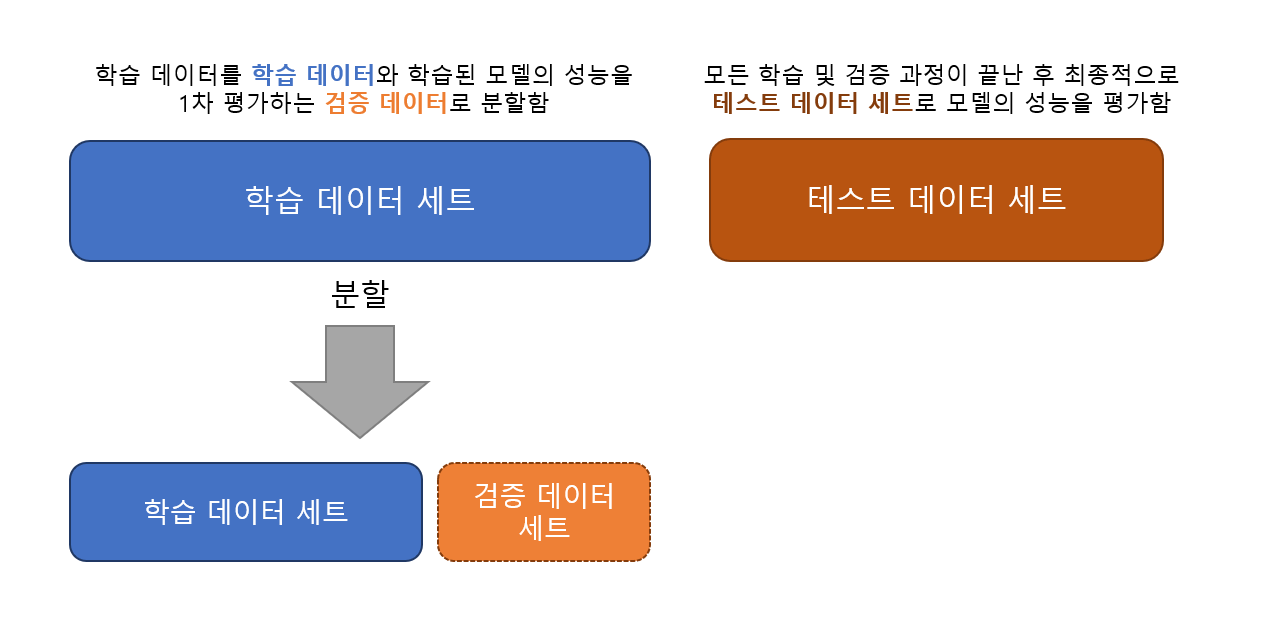

따라서 대부분의 머신러닝 모델은 <font color=purple>교차 검증을 기반으로 1차 성능 평가</font>를 한 뒤, <font color=purple>최종적으로 테스트 데이터 세트에 적용하여 평가</font>하는 과정을 거칩니다. <br>
그럼, 교차 검증 방법으로는 어떤 게 있을까요?

---

## 9.1 홀드 아웃(Hold-Out)

**<font color=red>홀드 아웃(Hold-Out)</font>** 은 전통적인 데이터 분할 방법입니다. <br>
`데이터를 무작위로 학습 데이터와 테스트 데이터 두 가지로 구분한 다음, 다시 학습 데이터는 학습 데이터와 검증 데이터로 분할`됩니다. 

이때 학습 데이터로 모델을 학습시키고, 검증 데이터로 모델의 성능을 평가하며 최적 파라미터를 찾아나갑니다.

그런 다음, 테스트 데이터를 이용해 최종적으로 모델의 성능을 평가하는 것이죠 😮



기본적인 문법 형태는 다음과 같아요. <br>
* `train_test_split(X, y, test_size=ㅁ, random_state=ㅁ)` <br>




① **test_size** : 전체 데이터에서 테스트 데이터의 크기를 얼마로 샘플링할 것인지를 결정하는 파라미터 <br>
② **random_state**: 호출할 때마다 동일한 학습/테스트용 데이터 세트를 생성하기 위해 주어지는 난수


그럼 직접 코드를 작성해볼까요? **RMSE**를 이용해 성능 평가도 함께 수행해보겠습니다 😊

In [31]:
# scikit-learn 패키지의 train_test_split()을 불러옵니다.
from sklearn.model_selection import train_test_split

# scikit-learn 패키지의 mean_squared_error을 불러옵니다.
from sklearn.metrics import mean_squared_error

그런데, 여기서 문제가 있습니다 😮 <br>
sklearn 패키지에서는 MSE만 제공한다는 것인데요.

우리는 RMSE 값을 구하는 게 목적이므로, `def`을 이용해서 RMSE를 계산하는 함수를 만들어 사용하겠습니다!

In [32]:
# RMSE 계산 함수
def RMSE(y_real,y_pred):
  return mean_squared_error(y_real, y_pred)**0.5

In [33]:
# 모델을 학습하고 예측합니다.
model_rf = rf.fit(X_train, y_train)

In [34]:
# 학습 데이터와 학습용과 검증용으로 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델을 학습하고 예측합니다.
model_rf = rf.fit(X_train, y_train)
rf_pred = model_rf.predict(X_test)

# 모델의 성능을 RMSE로 측정합니다.
print(RMSE(y_test, rf_pred))

0.21325976911557626


RMSE값이 약 0.213이 나왔군요 !

홀드아웃 방법은 데이터가 충분히 많으면 잘 작동할 수 있지만, <br>
반대로 데이터가 적은 경우 어떤 데이터가 검증용 데이터로 선택되느냐에 따라 큰 차이를 보인다는 단점이 존재해요 😥



그래서 이러한 차이를 최소화하는 방법으로 다음의 K-Fold 교차 검증을 사용하게 됩니다!

---

## 9.2 K-Fold 교차 검증

<font color=red>**K-Fold 교차 검증**</font>은 가장 보편적으로 사용되는 교차 검증 기법이라고 할 수 있어요 😊 <br>
`K개의 분할된 데이터 폴드 세트를 만들어 K번만큼 각 폴드 세트에 학습과 검증 평가를 반복적으로 수행하는 방법`이에요.



`교차검증을 사용하는 이유`는 데이터를 학습용과 검증용 세트로 여러 번 나눈 것의 평균적인 성능을 계산하면, <br>
한 번 나눠서 학습하는 것에 비해 일반화된 성능을 얻을 수 있기 때문이에요. <br>
따라서 홀드아웃 방법과 비교했을 때, 교차검증은 보다 안정적이고 정확한 방법이라고 할 수 있겠죠? 👍

`기본적인 문법 형태`는 다음과 같습니다. <br>
* `KFold(n_splits=ㅁ, shuffle=True/False, random_state=ㅁ)`


① **n_splits**: K-Fold 교차검증을 몇 번 수행할 것인지 지정함 (기본값=5) <br>
② **shuffle**: 데이터를 분리하기 전에 미리 무작위로 섞을지를 결정함 (기본값=True)

이때 <font color=green>shuffle</font>은 데이터를 분산시켜서 좀 더 효율적인 학습 및 테스트 데이터 세트를 만들기 위해 사용되는 파라미터입니다.

이번에는 `K-Fold 교차검증의 절차`를 알아볼게요 😀 <br>

* **k=5**라고 가정했을 때, 데이터를 5등분으로 분할해요.
* 그런 다음, 분할된 데이터 세트를 학습과 검증을 위한 데이터 세트로 변경하면서 5번 평가를 수행해요.
* 마지막으로, 이 5개의 평가를 평균한 결과를 가지고 예측 성능을 평가해요.

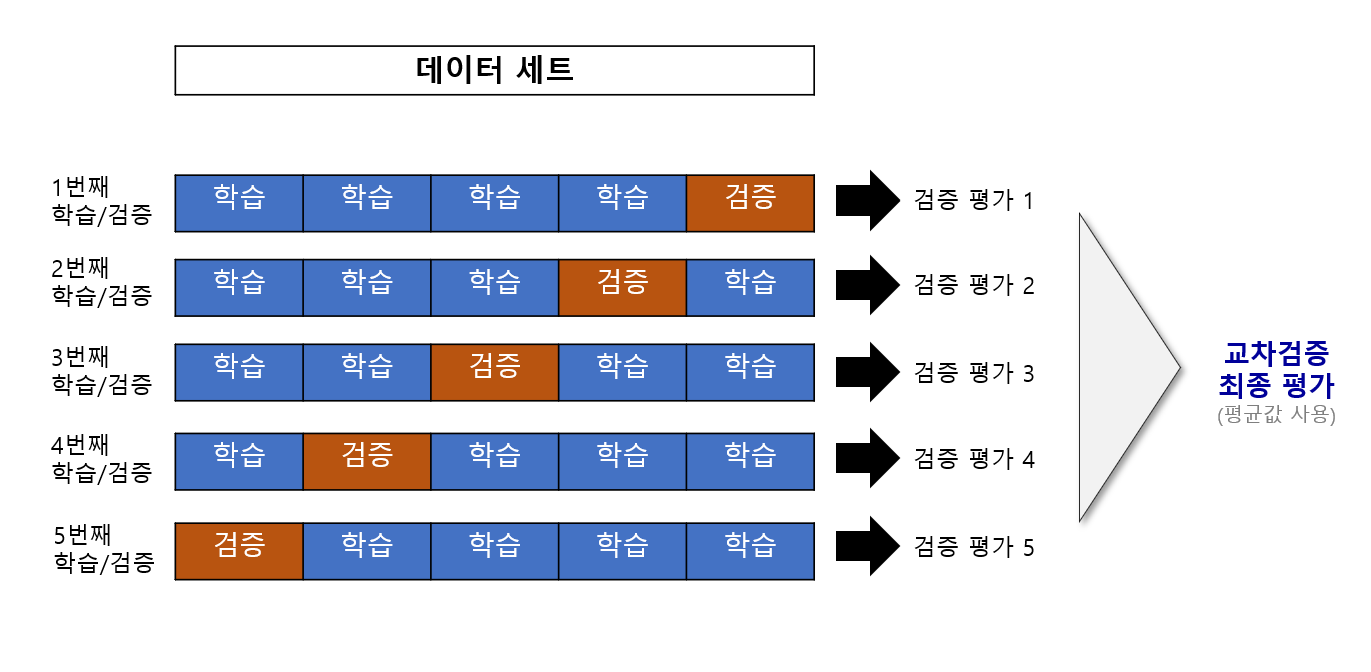

위 그림처럼, 학습 데이터 세트와 검증 데이터 세트를 점진적으로 변경하면서 마지막 5번째까지 학습과 검증을 수행해요. <br>
이를 통해 5개의 예측 평가 값을 구했다면, 마지막으로 이를 평균해서 K-Fold의 평가 결과로 반영하면 됩니다.

---

## 9.3 계층적(Stratified) K-Fold 교차 검증

일반적으로 분류(Classification) 문제에서는 K-Fold가 아닌 계층적 K-Fold 방법을 사용하는 것이 좋은데요 😮 <br>


<font color=red>**계층적 K-Fold 교차검증**</font>는 `불균형한 분포를 가진 레이블 데이터 집합을 위한 K-Fold 방식`입니다. <br>
즉, 특정 레이블 값이 매우 많거나 적어서 값의 분포가 한쪽으로 치우친 경우 사용합니다!



예를 들어, 대출 사기 데이터를 예측한다고 가정해볼게요 🙂 <br>
데이터는 총 1억 건이고, 여러 개의 변수와 대출 사기 여부를 의미하는 레이블(정상: 0, 대출사기: 1)로 구성되어 있습니다. <br>


1억 건의 데이터 중에서 대출 사기가 1,000건만 존재한다면, 즉 1의 값이 아주 작은 비율이라면 <br>
K-Fold로 랜덤하게 학습 및 테스트 데이터 세트를 고르더라도 레이블 값인 0과 1의 비율을 제대로 반영하지 못하는 경우가 쉽게 발생할 것입니다 😥

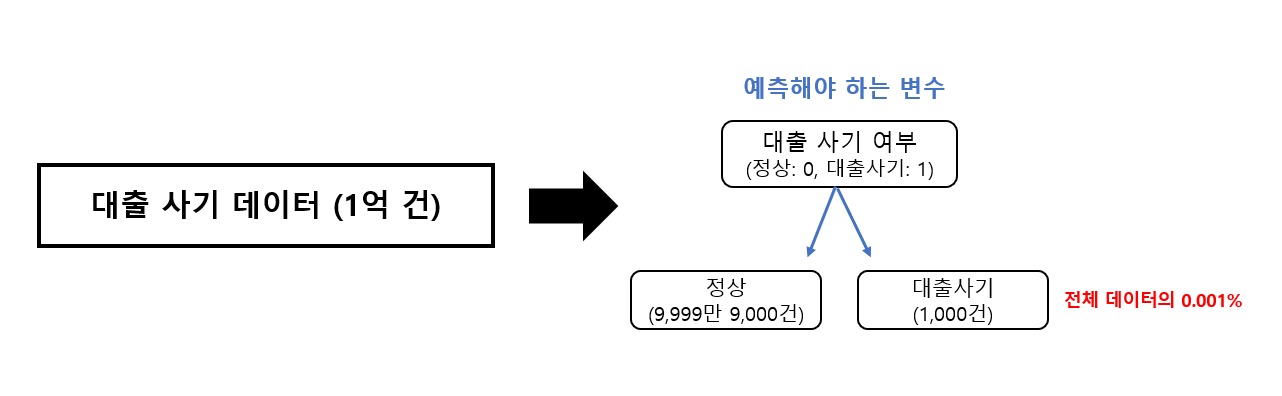

그런데 대출 사기인 경우의 데이터 수는 매우 적지만, 모델이 대출 사기 여부를 예측하기 위해서는 아주 중요한 데이터일 거에요. <br>
따라서 원본 데이터와 유사한 대출 사기 레이블 값의 분포를 학습 및 테스트 데이터 세트에도 유지하는 게 매우 중요합니다.

이럴 때 계층적 K-Fold 교차검증을 사용하면, <br>
원본 데이터의 레이블 분포를 우선 고려한 뒤 이 분포와 동일하게 학습 및 검증 데이터 세트를 분배합니다. 



앗, 물론, 우리가 해야 할 아파트 실거래가 예측처럼 **회귀(Regression) 문제**에서는 <br>
일반적으로 **계층적 K-Fold 교차검증은 사용하지 않는다는 것**을 유의해주세요! 😊

---

## 9.4 cross_val_score()

사실, 교차 검증을 파이썬에서 구현하려면 꽤나 복잡한데요.. 😂 <br>
그래서 사이킷런에서는 교차 검증을 좀 더 편리하게 수행할 수 있게 해주는 API가 존재한답니다! 정말 좋죠? 😎

대표적으로 `cross_val_score()`는 `KFold 교차검증을 위한 일련의 과정을 한꺼번에 수행해주는 API`에요. <br>
즉 API 내부에서 학습, 예측, 평가를 해주므로 교차 검증을 아주 간단하게 수행할 수 있어요. <br>



<font color=red>**cross_val_score()**</font>는 분류 모형에서는 **계층적 K-Fold 교차검증** 방식으로 레이블 값의 분포에 따라 학습/테스트 데이터를 분할합니다. <br>
반대로 우리가 앞서 생성한 랜덤포레스트 모형과 같이 회귀 모형의 경우에는 **K-Fold 교차검증** 방식에 따라 분할되어요.



기본적인 문법 형태는 다음과 같습니다. <br>
* `cross_val_score(모델이 할당된 객체, X, y, scoring='평가지표', cv=ㅁ)`



① **scoring** : 예측 성능을 평가하는 지표를 기술하는 파라미터 <br>
② **cv** : 교차검증 폴드 개수



자, 그럼 이제 교차 검증을 수행해볼까요?

In [35]:
# scikit-learn 패키지의 cross_val_score()를 불러옵니다.
from sklearn.model_selection import cross_val_score

In [36]:
# scikit-learn 패키지의 K-Fold 교차검증을 위한 클래스를 불러옵니다.
from sklearn.model_selection import KFold

앗, 잠시만요! 주의할 점이 있어요 😮 <br>


**cross_val_score** 함수를 사용하면 KFold의 파라미터를 제어할 수 없게 돼요.

그러니 우리는 kfold 객체를 만들어 cross_val_score 함수의 cv 파라미터로 전달해볼게요.

In [37]:
# 5개의 Fold를 분리하여 kfold 객체에 할당합니다.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
# 5 Fold 세트로 MSE 값을 구한 뒤, 이를 기반으로 다시 RMSE를 계산합니다.
neg_mse_scores = cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv=kfold)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [39]:
# 5 Fold의 평균 RMSE 값을 출력합니다.
print(avg_rmse)

0.2171857030644066


k=5에서 K-Fold 교차검증 결과, RMSE 값이 0.217으로 나왔습니다 !

잠깐! 여기서 짚고 넘어가야 할 부분이 있습니다. <br>


scoring 파라미터를 <font color=green>neg_mean_squared_error</font>로 지정한 이유가 무엇일까요? 그리고 앞에 붙은 `neg`는 무슨 의미일까요? 



흠.... 🤔 scoring 파라미터에 대해 조금 더 알아봐야겠어요.

---

## 9.5 scoring 파라미터

MSE와 같은 `회귀 성능평가 지표`의 경우, 'neg_mean_squared_error'처럼 앞에 `neg`라는 단어가 붙습니다.



사이킷런의 교차검증 기능은 scoring 매개변수에 비용함수가 아닌 <font color=hotpink>효용함수</font>를 기대하기 때문에, <br>
MSE의 반대값(=음수값)을 계산하는 'neg_mean_squared_error' 함수를 이용하는 것입니다. <br>



그런데 우리 대회에서는 성능평가 지표로 MSE가 아닌 RMSE를 사용합니다. <br>
하지만 안타깝게도... 사이킷런에서는 RMSE 함수를 직접적으로 지원하지 않아요 😥 <br>



따라서, 다음과 같은 절차를 거쳐 RMSE 값을 계산할 수 있습니다 😊

* `scoring = neg_mean_squared_error`로 지정하여, MSE의 음수값을 계산합니다. <br>
* 그런 다음, 반환된 MSE 값에 -1을 곱함으로써 양수로 만들어줍니다. <br>
* 마지막으로 이 값에 루트를 씌워 RMSE 값을 계산합니다.



이제 scoring 파라미터를 더 잘 이해하게 되었으니, 교차 검증을 다시 수행해볼까요?

In [40]:
# 5 Fold 세트로 MSE 값을 구한 뒤, 이를 기반으로 다시 RMSE를 계산합니다.
neg_mse_scores = cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv=kfold)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)

# 5개의 RMSE 값의 평균을 구하기 위해 numpy 패키지의 mean()을 활용합니다.
avg_rmse = np.mean(rmse_scores)

# 계산 결과를 출력합니다.
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 4))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 4))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-0.047  -0.0472 -0.0472 -0.047  -0.0474]
 5 folds 의 개별 RMSE scores :  [0.2167 0.2173 0.2174 0.2169 0.2176]
 5 folds 의 평균 RMSE : 0.217 


와우! 평균 RMSE 값이 0.217로 계산되었네요 👍

---

## 퀴즈

In [ ]:
# 성능평가 지표로 MAE, 교차검증 폴드 개수를 10으로 지정해서 교차검증을 수행하고 10 fold의 평균 MAE 값을 출력해주세요.


### 설명

scoring 파라미터로 회귀 성능평가 지표인 MAE를 지정하면 앞에 **neg**가 붙기 때문에, <br>
반환된 MAE 값에 (-1)을 곱해주는 과정이 필요합니다.

### 풀이 - 힌트

scoring 파라미터를 'neg_mean_absolute_error', cv 파라미터의 값을 10으로 설정합니다.

### 풀이 - 정답

```
# 10 Fold 세트로 MAE를 구한 뒤 (-1)을 곱해준 다음 평균 MAE 값을 계산합니다.
neg_mae_scores = cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=10)
mae_scores = (-1) * neg_mae_scores
avg_mae = np.mean(mae_scores)

# 평균 MAE 값을 출력합니다.
print(avg_mae)
```

데이커 여러분, 지금까지 따라오느라 수고 많으셨습니다 👏👏

Stage 5에서는 부스팅 모델에 대해 알아보고 실습해볼 예정이니, <br>
많은 사랑과 관심 부탁드립니다 ❤

---